## Librerías

In [1]:
import numpy as np 
import pandas as pd
import joblib
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
from skimage import feature, data, color 
import os
from tqdm import tqdm 
from skimage.transform import resize 
from skimage.io import imread
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain 
from scipy import stats 
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from utils import optimize_model_and_faces_with_optuna, mlp_param_transformer, plot_optimization_results, plot_pca_analysis #, extract_patches

#Metricas de performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
os.getcwd()

'/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio'

## Importar Caras y Fondos

In [3]:
suffix = '.pgm'

all_files = os.listdir('Faces/')
pgm_files = [filename for filename in all_files if filename.endswith(suffix)]

In [4]:
positive_patches = []
for filename in tqdm(pgm_files):
  path = 'Faces/' + filename
  with open(path, 'rb') as pgmf:
      image = plt.imread(pgmf)
  positive_patches.append(image)

100%|██████████| 12833/12833 [00:02<00:00, 5572.58it/s]


In [5]:
positive_patches = np.array(positive_patches)
positive_patches.shape

(12833, 64, 64)

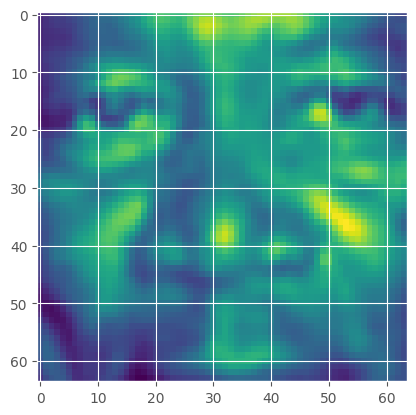

In [6]:
plt.imshow(positive_patches[1])
plt.show()

In [7]:
# Función para extraer porciones de una imagen
def extract_patches(img, N, scale=1.0, patch_size = (64, 64)):
    # Calcula el tamaño del parche extraído basado en el factor de escala dado
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))

    # Inicializa un objeto PatchExtractor con el tamaño de parche calculado,
    # el número máximo de parches, y una semilla de estado aleatorio
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)

    # Extrae parches de la imagen dada
    # img[np.newaxis] se utiliza la entrada de PatchExtractor es un conjunto de imágenes
    patches = extractor.transform(img[np.newaxis])

    # Si el factor de escala no es 1, redimensiona cada parche extraído
    # al tamaño del parche original
    if scale != 1:
        patches = np.array([resize(patch, patch_size) for patch in patches])

    # Devuelve la lista de parches extraídos (y posiblemente redimensionados)
    return patches

In [8]:
# Tomamos algunas imágenes de sklearn
imgs = ['text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field'
        ]

images = []
for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
        # img = (img * 255).astype(np.uint8)
    images.append(resize(img, (100,100)))

# Imagenes caseras adicionales
background_files = [f for f in os.listdir('Generar_Fondos') if f.endswith('.jpg')]
for filename in background_files:
    img = plt.imread('Generar_Fondos/' + filename)
    img = color.rgb2gray(img)
    images.append(resize(img, (100,100)))

In [9]:
# Extraemos las imágenes de fondo
negative_patches = np.vstack([extract_patches(im, 64, scale) for im in tqdm(images, desc='Procesando imágenes') for scale in [0.1,0.25,0.5,0.75,1]])
negative_patches.shape

Procesando imágenes: 100%|██████████| 60/60 [00:01<00:00, 49.34it/s]


(19200, 64, 64)

In [10]:
P = len(positive_patches)
N = len(negative_patches)

In [11]:
positive_patches = np.array(positive_patches)
print('positive_patches:',positive_patches.shape)

negative_patches = np.array(negative_patches)
print('negative_patches:',negative_patches.shape)

positive_patches: (12833, 64, 64)
negative_patches: (19200, 64, 64)


In [12]:
positive_patches

array([[[ 93, 109, 118, ..., 141, 141, 128],
        [ 88, 105, 116, ..., 136, 139, 134],
        [ 91, 105, 116, ..., 131, 135, 135],
        ...,
        [ 38,  34,  27, ..., 153, 188, 220],
        [ 35,  32,  26, ..., 199, 229, 234],
        [ 33,  32,  29, ..., 228, 240, 225]],

       [[ 68,  72,  76, ...,  88,  84,  82],
        [ 68,  73,  76, ...,  88,  87,  87],
        [ 69,  73,  75, ...,  87,  89,  90],
        ...,
        [ 84,  94,  96, ...,  99,  93,  88],
        [ 79,  90,  94, ...,  97,  92,  88],
        [ 74,  85,  90, ...,  94,  89,  88]],

       [[105, 109, 112, ..., 175, 166, 163],
        [105, 110, 113, ..., 173, 164, 159],
        [105, 109, 108, ..., 174, 166, 160],
        ...,
        [145, 140, 105, ..., 208, 146,  49],
        [132, 139, 115, ..., 208, 144,  40],
        [126, 133, 116, ..., 208, 148,  37]],

       ...,

       [[138, 142, 145, ..., 163, 148, 131],
        [141, 146, 148, ..., 162, 146, 129],
        [143, 149, 150, ..., 160, 145, 130

In [13]:
negative_patches

array([[[0.4317259 , 0.44254155, 0.45335721, ..., 0.50870194,
         0.50773631, 0.50677068],
        [0.4288775 , 0.43963401, 0.45039052, ..., 0.50785415,
         0.50678211, 0.50571007],
        [0.42602909, 0.43672646, 0.44742383, ..., 0.50700636,
         0.50582791, 0.50464945],
        ...,
        [0.56926828, 0.57183059, 0.57439289, ..., 0.39606439,
         0.40072611, 0.40538783],
        [0.56836983, 0.57090794, 0.57344605, ..., 0.40158727,
         0.40453217, 0.40747706],
        [0.56747138, 0.56998529, 0.5724992 , ..., 0.40711015,
         0.40833822, 0.40956629]],

       [[0.50395018, 0.50259958, 0.50124898, ..., 0.36731131,
         0.37341773, 0.37952414],
        [0.5063919 , 0.50499438, 0.50359686, ..., 0.35747061,
         0.36429876, 0.3711269 ],
        [0.50883362, 0.50738918, 0.50594473, ..., 0.34762991,
         0.35517979, 0.36272966],
        ...,
        [0.44839405, 0.43843179, 0.42846954, ..., 0.46971596,
         0.47061423, 0.47151251],
        [0.4

In [14]:
negative_patches = (negative_patches*255).astype(np.uint8)

negative_patches

array([[[110, 112, 115, ..., 129, 129, 129],
        [109, 112, 114, ..., 129, 129, 128],
        [108, 111, 114, ..., 129, 128, 128],
        ...,
        [145, 145, 146, ..., 100, 102, 103],
        [144, 145, 146, ..., 102, 103, 103],
        [144, 145, 145, ..., 103, 104, 104]],

       [[128, 128, 127, ...,  93,  95,  96],
        [129, 128, 128, ...,  91,  92,  94],
        [129, 129, 129, ...,  88,  90,  92],
        ...,
        [114, 111, 109, ..., 119, 120, 120],
        [115, 112, 110, ..., 119, 119, 120],
        [116, 113, 111, ..., 119, 119, 119]],

       [[141, 141, 141, ..., 147, 147, 146],
        [141, 141, 141, ..., 147, 147, 146],
        [141, 141, 141, ..., 147, 147, 147],
        ...,
        [142, 142, 142, ..., 146, 146, 145],
        [142, 142, 141, ..., 146, 146, 146],
        [141, 141, 141, ..., 146, 146, 146]],

       ...,

       [[104, 107, 110, ..., 201, 194, 204],
        [106, 110, 113, ..., 190, 196, 201],
        [121, 129, 133, ..., 214, 206, 211

In [15]:
X = np.array([feature.hog(im) for im in tqdm(chain(positive_patches, negative_patches), desc='Construyendo X')])
y = np.zeros(len(X))
y[:P] = 1

Construyendo X: 32033it [00:13, 2312.66it/s]


In [16]:
X

array([[0.11646401, 0.03128126, 0.00558129, ..., 0.        , 0.01059255,
        0.03064134],
       [0.05215952, 0.01875931, 0.08044653, ..., 0.03149585, 0.09934855,
        0.13186444],
       [0.09338918, 0.01034122, 0.00889002, ..., 0.00365123, 0.01220339,
        0.15453749],
       ...,
       [0.01412594, 0.        , 0.01198015, ..., 0.11166409, 0.24912053,
        0.04256966],
       [0.19824994, 0.07418107, 0.02699928, ..., 0.05689269, 0.13233471,
        0.1334669 ],
       [0.06520012, 0.00221218, 0.00569407, ..., 0.02781517, 0.06629227,
        0.        ]])

In [17]:
y

array([1., 1., 1., ..., 0., 0., 0.])

# Modelos

## Neural Network

In [18]:
from sklearn.neural_network import MLPClassifier  

In [19]:
params = {
    # Arquitectura de la red
    'n_layers': {'type': 'int', 'low': 1, 'high': 3}, # Número de capas ocultas
    'n_units_l0': {'type': 'int', 'low': 32, 'high': 256, 'log': True}, # Neuronas para la primera capa
    'n_units_l1': {'type': 'int', 'low': 32, 'high': 256, 'log': True}, # Neuronas para la segunda capa (si n_layers >= 2)
    'n_units_l2': {'type': 'int', 'low': 32, 'high': 256, 'log': True}, # Neuronas para la tercera capa (si n_layers == 3)

    # Función de activación
    'activation': {'type': 'categorical', 'choices': ['relu', 'tanh']},

    # Algoritmo de optimización
    'solver': {'type': 'categorical', 'choices': ['adam', 'sgd']},

    # Regularización L2
    'alpha': {'type': 'float', 'low': 1e-5, 'high': 1e-2, 'log': True}, # Término de penalización L2

    # Tasa de aprendizaje inicial (especialmente relevante para 'sgd', 'adam' la gestiona mejor)
    'learning_rate_init': {'type': 'float', 'low': 1e-4, 'high': 1e-2, 'log': True},

    # Tamaño del batch (si el solver lo soporta, como 'adam' o 'sgd')
    'batch_size': {'type': 'categorical', 'choices': [32, 64, 128]}, # Comunes para datasets medianos

    # Número máximo de iteraciones (épocas)
    'max_iter': {'type': 'int', 'low': 200, 'high': 1000},

    # Parámetros específicos para el solver 'sgd'
    'momentum': {'type': 'float', 'low': 0.8, 'high': 0.99}, # Aplicable solo si solver='sgd'
    'nesterovs_momentum': {'type': 'categorical', 'choices': [True, False]} # Aplicable solo si solver='sgd'
}

In [20]:
from sklearn.neural_network import MLPClassifier

# Definir parámetros personalizados para MLP
mlp_params = {
    'n_layers': {'type': 'int', 'low': 1, 'high': 3},
    'n_units_l0': {'type': 'int', 'low': 32, 'high': 256},
    'n_units_l1': {'type': 'int', 'low': 32, 'high': 256}, 
    'n_units_l2': {'type': 'int', 'low': 32, 'high': 256},
    'activation': {'type': 'categorical', 'choices': ['relu', 'tanh']},
    'solver': {'type': 'categorical', 'choices': ['adam', 'sgd']},
    'alpha': {'type': 'float', 'low': 1e-5, 'high': 1e-2, 'log': True},
    'learning_rate_init': {'type': 'float', 'low': 1e-4, 'high': 1e-2, 'log': True},
    'batch_size': {'type': 'categorical', 'choices': [32, 64, 128]},
    'max_iter': {'type': 'int', 'low': 200, 'high': 1000}
}

# Ejecutar optimización CON el transformador de parámetros
results = optimize_model_and_faces_with_optuna(
    positive_patches, 
    negative_patches,
    model_class=MLPClassifier,
    param_distributions=mlp_params,
    param_transformer=mlp_param_transformer, 
    n_trials=20,
    optimize_faces=True,
    optimize_pca=False,
    fixed_pca_params={'n_components': 500, 'whiten': True}
)

/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-29 19:15:07,655] A new study created in memory with name: no-name-f3d3eb36-82c3-4f88-9164-60c01ee2ab1b


Starting model-agnostic optimization with Optuna...
Model: MLPClassifier
Using 5-fold cross-validation for optimization
Parameters to optimize: ['n_layers', 'n_units_l0', 'n_units_l1', 'n_units_l2', 'activation', 'solver', 'alpha', 'learning_rate_init', 'batch_size', 'max_iter']
Also optimizing: Number of faces (P)
Trials: 20


  0%|          | 0/20 [00:00<?, ?it/s]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(
Best trial: 0. Best value: 0.991206:   5%|▌         | 1/20 [00:35<11:12, 35.41s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 19:15:43,060] Trial 0 finished with value: 0.9912059650438927 and parameters: {'n_layers': 2, 'n_units_l0': 240, 'n_units_l1': 243, 'n_units_l2': 104, 'activation': 'tanh', 'solver': 'adam', 'alpha': 6.852396667538412e-05, 'learning_rate_init': 0.0006696948532277355, 'batch_size': 128, 'max_iter': 836, 'n_positive_samples': 9500}. Best is trial 0 with value: 0.9912059650438927.


Best trial: 1. Best value: 0.99258:  10%|█         | 2/20 [01:59<19:07, 63.77s/it] /Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 19:17:06,689] Trial 1 finished with value: 0.9925798560605538 and parameters: {'n_layers': 1, 'n_units_l0': 227, 'n_units_l1': 162, 'n_units_l2': 208, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0013860722827677503, 'learning_rate_init': 0.00024649622284732194, 'batch_size': 32, 'max_iter': 922, 'n_positive_samples': 12000}. Best is trial 1 with value: 0.9925798560605538.


Best trial: 1. Best value: 0.99258:  15%|█▌        | 3/20 [02:14<11:49, 41.76s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 19:17:22,250] Trial 2 finished with value: 0.9853595769582011 and parameters: {'n_layers': 1, 'n_units_l0': 47, 'n_units_l1': 112, 'n_units_l2': 77, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0026902769980306435, 'learning_rate_init': 0.005939156957617732, 'batch_size': 64, 'max_iter': 284, 'n_positive_samples': 3500}. Best is trial 1 with value: 0.9925798560605538.


Best trial: 1. Best value: 0.99258:  20%|██        | 4/20 [03:12<12:49, 48.11s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 19:18:20,101] Trial 3 finished with value: 0.9780577850596043 and parameters: {'n_layers': 3, 'n_units_l0': 98, 'n_units_l1': 248, 'n_units_l2': 237, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0017076270957047375, 'learning_rate_init': 0.00017178171484046875, 'batch_size': 128, 'max_iter': 493, 'n_positive_samples': 6000}. Best is trial 1 with value: 0.9925798560605538.


Best trial: 1. Best value: 0.99258:  25%|██▌       | 5/20 [03:34<09:38, 38.60s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 19:18:41,830] Trial 4 finished with value: 0.9725999184876418 and parameters: {'n_layers': 3, 'n_units_l0': 51, 'n_units_l1': 253, 'n_units_l2': 150, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0009790612779498715, 'learning_rate_init': 0.0076982398306717, 'batch_size': 32, 'max_iter': 773, 'n_positive_samples': 4000}. Best is trial 1 with value: 0.9925798560605538.


Best trial: 1. Best value: 0.99258:  30%|███       | 6/20 [03:51<07:19, 31.38s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 19:18:59,210] Trial 5 finished with value: 0.9801816689152723 and parameters: {'n_layers': 3, 'n_units_l0': 83, 'n_units_l1': 73, 'n_units_l2': 186, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0013687129808450697, 'learning_rate_init': 0.006954072182399307, 'batch_size': 32, 'max_iter': 792, 'n_positive_samples': 1500}. Best is trial 1 with value: 0.9925798560605538.


Best trial: 1. Best value: 0.99258:  35%|███▌      | 7/20 [04:17<06:26, 29.74s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 19:19:25,567] Trial 6 finished with value: 0.9870817319914498 and parameters: {'n_layers': 3, 'n_units_l0': 43, 'n_units_l1': 45, 'n_units_l2': 162, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006600224405883535, 'learning_rate_init': 0.0008761554838865701, 'batch_size': 32, 'max_iter': 205, 'n_positive_samples': 5000}. Best is trial 1 with value: 0.9925798560605538.


Best trial: 1. Best value: 0.99258:  40%|████      | 8/20 [04:44<05:43, 28.60s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 19:19:51,712] Trial 7 finished with value: 0.9893692201292854 and parameters: {'n_layers': 2, 'n_units_l0': 211, 'n_units_l1': 41, 'n_units_l2': 198, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0002215433175531771, 'learning_rate_init': 0.00309131334255405, 'batch_size': 32, 'max_iter': 793, 'n_positive_samples': 4500}. Best is trial 1 with value: 0.9925798560605538.


Best trial: 1. Best value: 0.99258:  45%|████▌     | 9/20 [05:09<05:03, 27.59s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 19:20:17,080] Trial 8 finished with value: 0.9857560606751455 and parameters: {'n_layers': 3, 'n_units_l0': 102, 'n_units_l1': 165, 'n_units_l2': 250, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0012005751031752918, 'learning_rate_init': 0.008239407759629863, 'batch_size': 64, 'max_iter': 699, 'n_positive_samples': 10000}. Best is trial 1 with value: 0.9925798560605538.


Best trial: 1. Best value: 0.99258:  50%|█████     | 10/20 [05:27<04:05, 24.56s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 19:20:34,850] Trial 9 finished with value: 0.9891874332251348 and parameters: {'n_layers': 1, 'n_units_l0': 117, 'n_units_l1': 43, 'n_units_l2': 226, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001474267294062828, 'learning_rate_init': 0.006217407937785462, 'batch_size': 64, 'max_iter': 893, 'n_positive_samples': 3500}. Best is trial 1 with value: 0.9925798560605538.


Best trial: 1. Best value: 0.99258:  55%|█████▌    | 11/20 [06:31<05:31, 36.82s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 19:21:39,482] Trial 10 finished with value: 0.9922746321583749 and parameters: {'n_layers': 1, 'n_units_l0': 179, 'n_units_l1': 178, 'n_units_l2': 32, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 1.0351450923611579e-05, 'learning_rate_init': 0.00013809327925723547, 'batch_size': 32, 'max_iter': 547, 'n_positive_samples': 12500}. Best is trial 1 with value: 0.9925798560605538.


Best trial: 1. Best value: 0.99258:  60%|██████    | 12/20 [07:40<06:12, 46.56s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 19:22:48,301] Trial 11 finished with value: 0.9919465262275302 and parameters: {'n_layers': 1, 'n_units_l0': 177, 'n_units_l1': 178, 'n_units_l2': 35, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 1.1684350067445664e-05, 'learning_rate_init': 0.00010498467751171785, 'batch_size': 32, 'max_iter': 525, 'n_positive_samples': 12000}. Best is trial 1 with value: 0.9925798560605538.


Best trial: 1. Best value: 0.99258:  65%|██████▌   | 13/20 [08:30<05:33, 47.70s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 19:23:38,649] Trial 12 finished with value: 0.9918250934355439 and parameters: {'n_layers': 1, 'n_units_l0': 170, 'n_units_l1': 194, 'n_units_l2': 101, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 1.041922004203405e-05, 'learning_rate_init': 0.00031018703300122563, 'batch_size': 32, 'max_iter': 987, 'n_positive_samples': 12500}. Best is trial 1 with value: 0.9925798560605538.


Best trial: 1. Best value: 0.99258:  70%|███████   | 14/20 [09:42<05:29, 54.92s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 19:24:50,256] Trial 13 finished with value: 0.9914624456903736 and parameters: {'n_layers': 2, 'n_units_l0': 255, 'n_units_l1': 133, 'n_units_l2': 41, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.00021244730662553553, 'learning_rate_init': 0.00036687733479859937, 'batch_size': 32, 'max_iter': 413, 'n_positive_samples': 10000}. Best is trial 1 with value: 0.9925798560605538.


Best trial: 1. Best value: 0.99258:  75%|███████▌  | 15/20 [10:58<05:06, 61.21s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 19:26:06,031] Trial 14 finished with value: 0.9912001026166214 and parameters: {'n_layers': 1, 'n_units_l0': 211, 'n_units_l1': 208, 'n_units_l2': 118, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 4.334397848941954e-05, 'learning_rate_init': 0.00010018313112898945, 'batch_size': 32, 'max_iter': 634, 'n_positive_samples': 7500}. Best is trial 1 with value: 0.9925798560605538.


Best trial: 1. Best value: 0.99258:  80%|████████  | 16/20 [11:43<03:45, 56.50s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 19:26:51,590] Trial 15 finished with value: 0.9915447859490483 and parameters: {'n_layers': 1, 'n_units_l0': 156, 'n_units_l1': 136, 'n_units_l2': 190, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.000459325520530827, 'learning_rate_init': 0.0002512788275394848, 'batch_size': 128, 'max_iter': 395, 'n_positive_samples': 11500}. Best is trial 1 with value: 0.9925798560605538.


Best trial: 1. Best value: 0.99258:  85%|████████▌ | 17/20 [12:37<02:46, 55.56s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 19:27:44,973] Trial 16 finished with value: 0.9899585658910011 and parameters: {'n_layers': 2, 'n_units_l0': 200, 'n_units_l1': 103, 'n_units_l2': 79, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.00808544852736548, 'learning_rate_init': 0.0005507601684901577, 'batch_size': 32, 'max_iter': 605, 'n_positive_samples': 7500}. Best is trial 1 with value: 0.9925798560605538.


Best trial: 1. Best value: 0.99258:  90%|█████████ | 18/20 [13:04<01:34, 47.13s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 19:28:12,490] Trial 17 finished with value: 0.9917311278594194 and parameters: {'n_layers': 1, 'n_units_l0': 136, 'n_units_l1': 219, 'n_units_l2': 131, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 7.22684213618478e-05, 'learning_rate_init': 0.0024791830538973656, 'batch_size': 32, 'max_iter': 981, 'n_positive_samples': 11000}. Best is trial 1 with value: 0.9925798560605538.


Best trial: 1. Best value: 0.99258:  95%|█████████▌| 19/20 [13:29<00:40, 40.45s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 19:28:37,357] Trial 18 finished with value: 0.9904700579692172 and parameters: {'n_layers': 2, 'n_units_l0': 190, 'n_units_l1': 164, 'n_units_l2': 217, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0004433966639842081, 'learning_rate_init': 0.0015778415480318191, 'batch_size': 128, 'max_iter': 527, 'n_positive_samples': 8500}. Best is trial 1 with value: 0.9925798560605538.


Best trial: 1. Best value: 0.99258: 100%|██████████| 20/20 [14:39<00:00, 43.97s/it]


[I 2025-06-29 19:29:47,118] Trial 19 finished with value: 0.9918184789315552 and parameters: {'n_layers': 1, 'n_units_l0': 229, 'n_units_l1': 108, 'n_units_l2': 159, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0035082740971973557, 'learning_rate_init': 0.00019233730179199772, 'batch_size': 64, 'max_iter': 689, 'n_positive_samples': 12500}. Best is trial 1 with value: 0.9925798560605538.

Optimization completed!
Best CV F1-score: 0.9926
Best parameters:
  n_layers: 1
  n_units_l0: 227
  n_units_l1: 162
  n_units_l2: 208
  activation: tanh
  solver: sgd
  alpha: 0.0013860722827677503
  learning_rate_init: 0.00024649622284732194
  batch_size: 32
  max_iter: 922
  n_positive_samples: 12000

Training final model and evaluating on held-out test set...

=== FINAL RESULTS ===
Cross-validation F1-score (optimization): 0.9926
Test set F1-score (final evaluation): 0.9937
Best number of positive samples (P): 12000

Detailed test set results:
              precision    recall  f1-score   supp

In [21]:
results_nn = results

In [22]:
joblib.dump(results['trained_model'], 'models/nn_optimized.joblib') 

['models/nn_optimized.joblib']

In [23]:
from utils import plot_pca_analysis_plotly, confusion_matrix

In [24]:
plot_pca_analysis_plotly(results_nn, results_nn['X_train_pca'], results_nn['y_train'])

In [25]:
confusion_matrix_nn = confusion_matrix(results_nn)

Matriz de Confusión:
 [[3831    9]
 [  21 2379]]

Verdaderos Positivos (TP): 2379
Falsos Positivos (FP): 9
Falsos Negativos (FN): 21
Verdaderos Negativos (TN): 3831

TPR (Sensibilidad/Recall) calculado manualmente: 0.9912
FPR calculado manualmente: 0.0023


/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio/utils.py:401: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.

/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio/utils.py:405: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.

/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio/utils.py:411: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.

/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio/utils.py:414: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



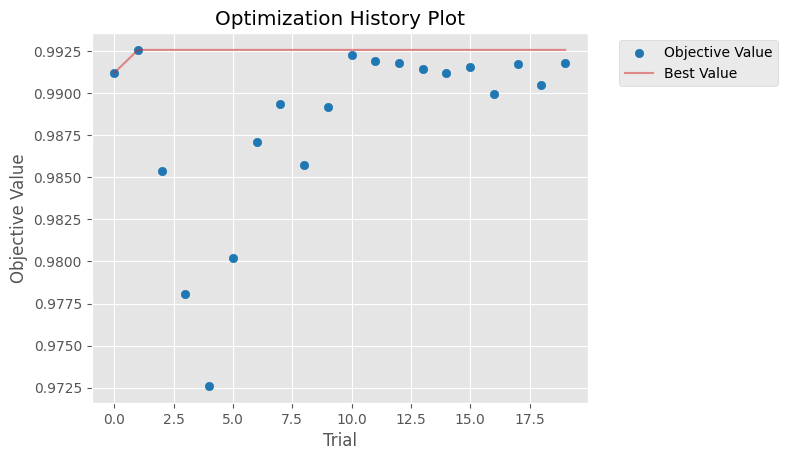

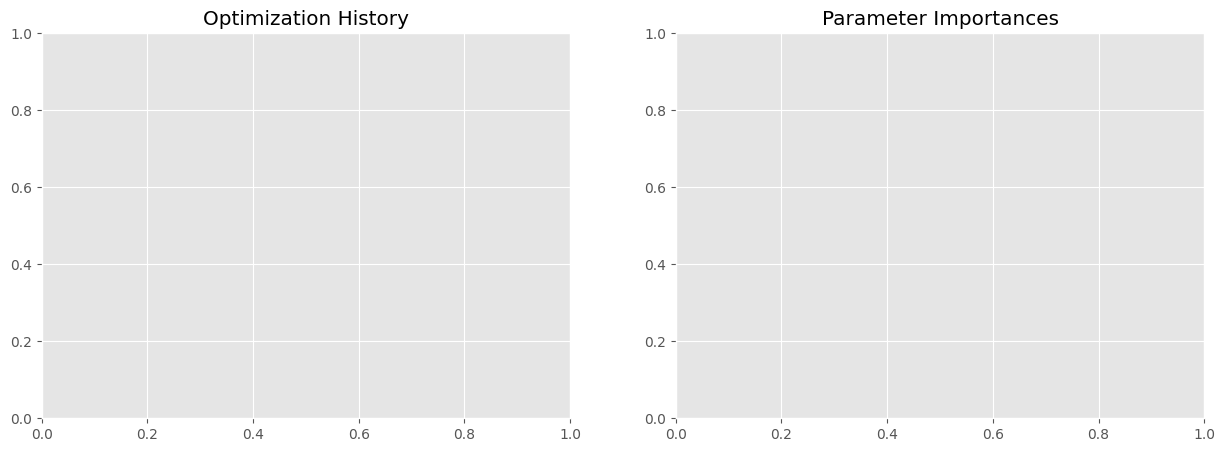

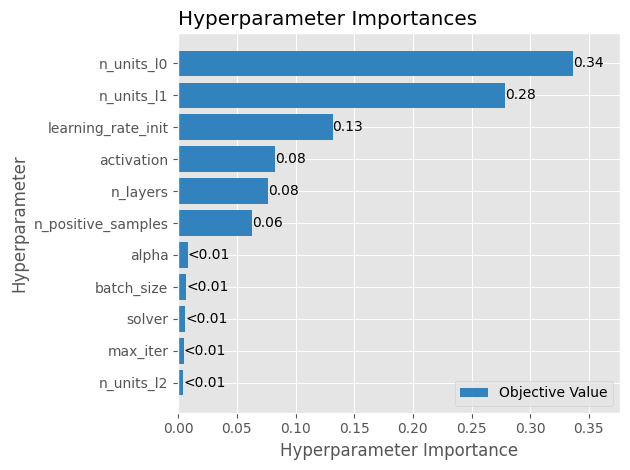

In [26]:
plot_optimization_results(results_nn['study'])

In [27]:
joblib.dump(results_nn['pca'], 'models/pca_nn.joblib')

joblib.dump(results_nn['scaler'], 'models/scaler_nn.joblib')

['models/scaler_nn.joblib']

## Gradient Boosting

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

In [29]:
params={
    'n_estimators': {'type': 'int', 'low': 50, 'high': 300, 'step': 10},
    'max_depth': {'type': 'int', 'low': 3, 'high': 10},
    'learning_rate': {'type': 'float', 'low': 0.01, 'high': 0.5, 'log': True},
    'subsample': {'type': 'float', 'low': 0.5, 'high': 1.0},
    'max_features': {'type': 'categorical', 'choices': ['sqrt', 'log2', None]}
}

In [30]:
results = optimize_model_and_faces_with_optuna(
    positive_patches, 
    negative_patches,
    model_class=GradientBoostingClassifier,
    param_distributions=params,
    n_trials=20,
    cv_folds=5,
    test_size=0.2,  
    random_state=42,
    n_jobs=-1,
    show_progress=True,
    optimize_faces=True,
    optimize_pca=False,
    fixed_pca_params={'n_components': 500, 'whiten': True}
)

[I 2025-06-29 19:31:33,012] A new study created in memory with name: no-name-dad467bb-5fdf-4986-ad33-636ccb8e43b4


Starting model-agnostic optimization with Optuna...
Model: GradientBoostingClassifier
Using 5-fold cross-validation for optimization
Parameters to optimize: ['n_estimators', 'max_depth', 'learning_rate', 'subsample', 'max_features']
Also optimizing: Number of faces (P)
Trials: 20


  0%|          | 0/20 [00:00<?, ?it/s]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



In [30]:
results_gb = results

In [ ]:
joblib.dump(results_gb['trained_model'], 'models/gradient_boosting_optimized.joblib')

['models/gradient_boosting_optimized.joblib']

In [ ]:
joblib.dump(results_gb['pca'], 'models/pca_gb.joblib')
joblib.dump(results_gb['scaler'], 'models/scaler_gb.joblib')


['models/pca_gb.joblib']

/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio/utils.py:400: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.

/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio/utils.py:404: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.

/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio/utils.py:410: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.

/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio/utils.py:413: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.

/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio/utils.py:423: ExperimentalWarning:

plot_parallel_coordinate is experimental (support

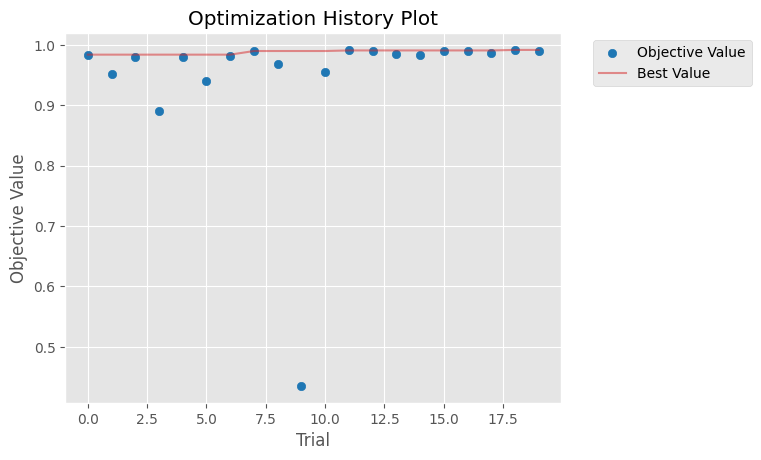

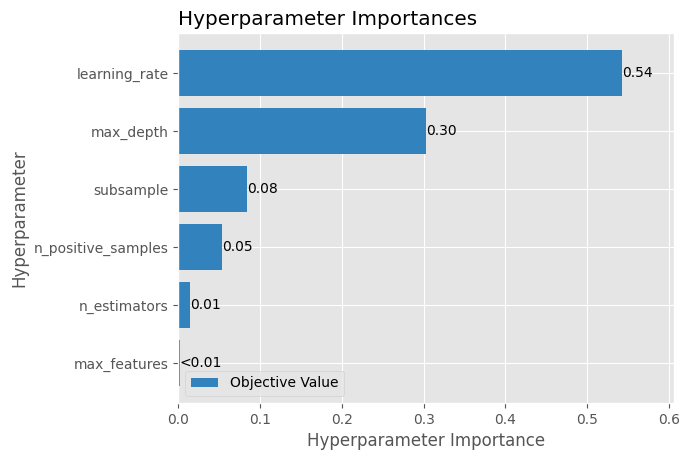

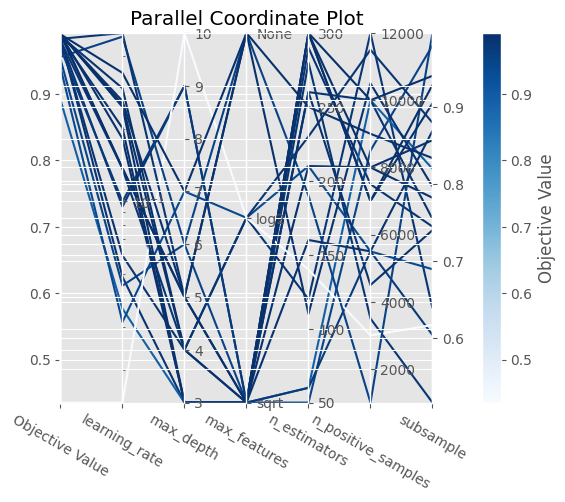

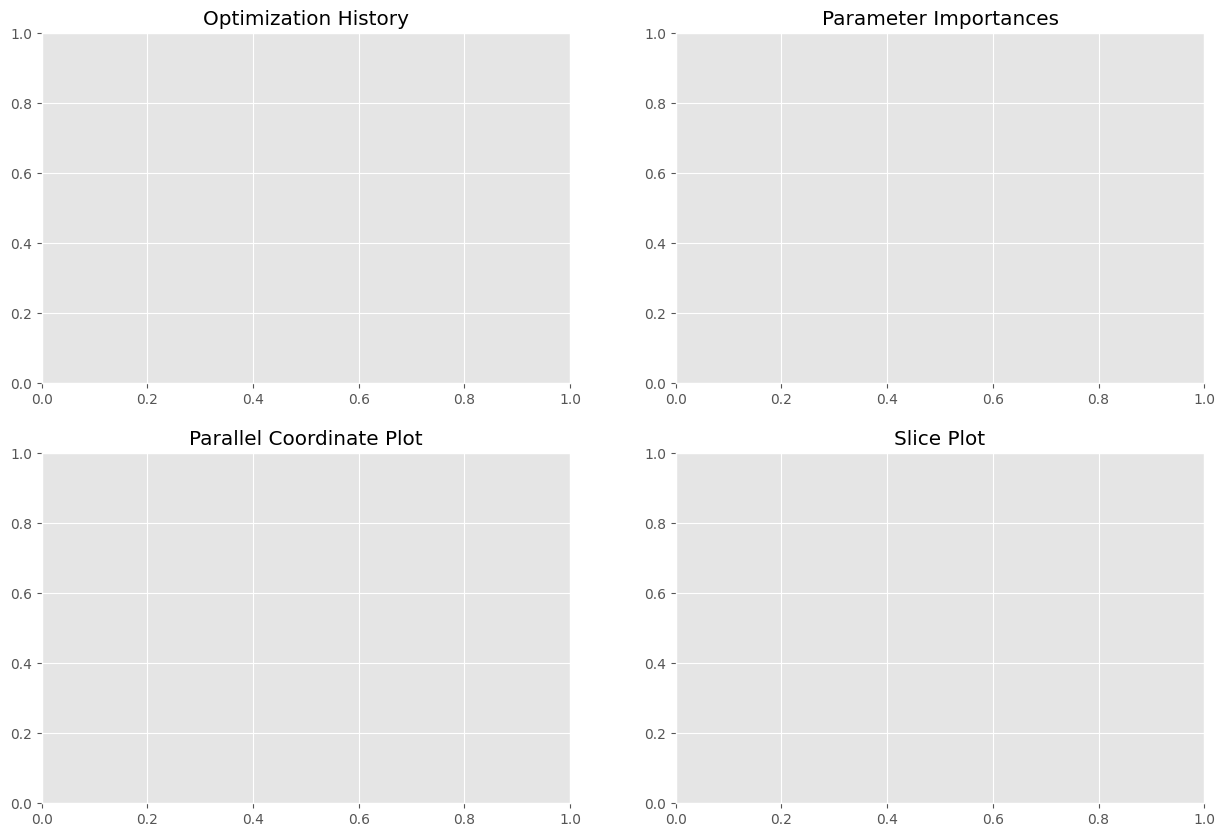

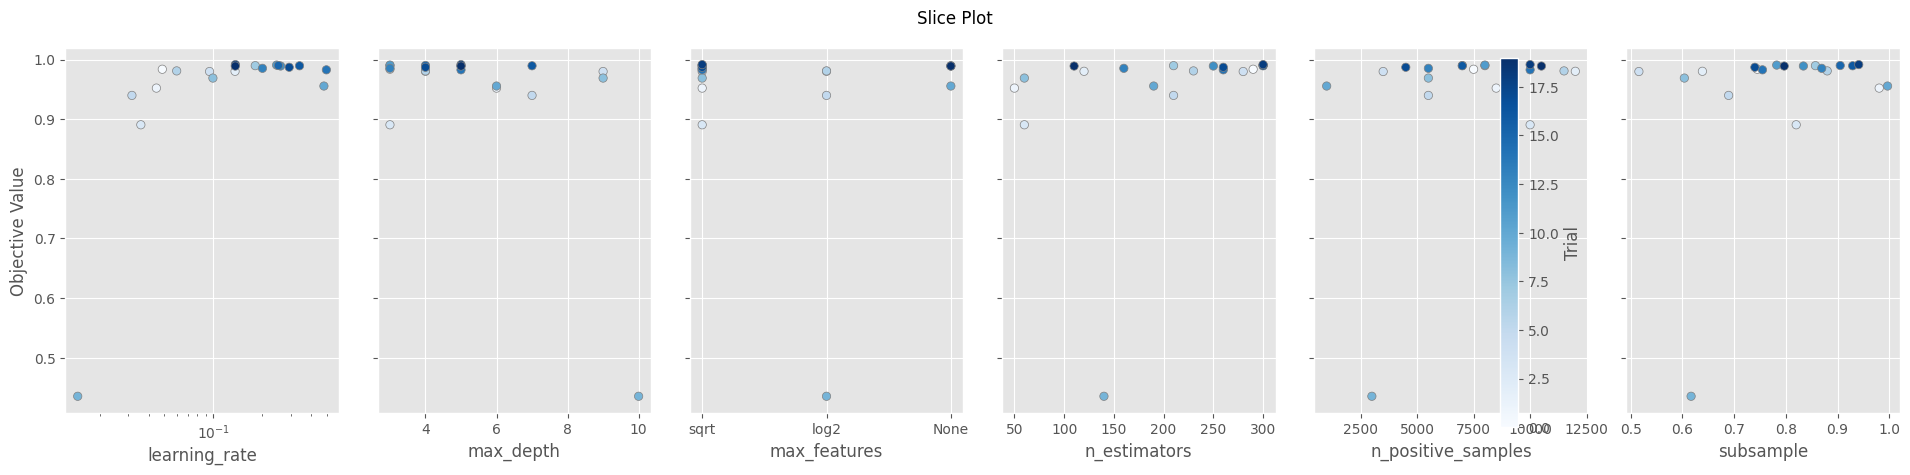

In [32]:
plot_optimization_results(results_gb['study'])

In [33]:
plot_pca_analysis_plotly(results_gb, results_gb['X_train_pca'], results_gb['y_train'])

In [46]:
confusion_matrix_gb = confusion_matrix(results_gb)

Matriz de Confusión:
 [[3839    1]
 [  22 1978]]

Verdaderos Positivos (TP): 1978
Falsos Positivos (FP): 1
Falsos Negativos (FN): 22
Verdaderos Negativos (TN): 3839

TPR (Sensibilidad/Recall) calculado manualmente: 0.9890
FPR calculado manualmente: 0.0003


## XGBoost

In [36]:
import xgboost as xgb

In [37]:
params = {
    'n_estimators': {'type': 'int', 'low': 50, 'high': 300, 'step': 10},
    'max_depth': {'type': 'int', 'low': 3, 'high': 12},
    'learning_rate': {'type': 'float', 'low': 0.01, 'high': 0.3, 'log': True},
    'subsample': {'type': 'float', 'low': 0.6, 'high': 1.0},
    'colsample_bytree': {'type': 'float', 'low': 0.6, 'high': 1.0},
    'gamma': {'type': 'float', 'low': 0, 'high': 5},
    'reg_alpha': {'type': 'float', 'low': 0, 'high': 2},
    'reg_lambda': {'type': 'float', 'low': 0, 'high': 2}
}

In [38]:
results = optimize_model_and_faces_with_optuna(
    positive_patches, 
    negative_patches,
    model_class=xgb.XGBClassifier,
    param_distributions=params,
    n_trials=20,
    cv_folds=5,
    test_size=0.2,  
    random_state=42,
    n_jobs=-1,
    show_progress=True,
    optimize_faces=True,
    optimize_pca=False,
    fixed_pca_params={'n_components': 500, 'whiten': True}
)

[I 2025-06-29 17:45:03,187] A new study created in memory with name: no-name-31517830-15d4-48aa-b23e-e4a5aa66a1af


Starting model-agnostic optimization with Optuna...
Model: XGBClassifier
Using 5-fold cross-validation for optimization
Parameters to optimize: ['n_estimators', 'max_depth', 'learning_rate', 'subsample', 'colsample_bytree', 'gamma', 'reg_alpha', 'reg_lambda']
Also optimizing: Number of faces (P)
Trials: 20


  0%|          | 0/20 [00:00<?, ?it/s]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].

Best trial: 0. Best value: 0.9665:   5%|▌         | 1/20 [00:19<06:01, 19.02s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



[I 2025-06-29 17:45:22,204] Trial 0 finished with value: 0.966499788519841 and parameters: {'n_estimators': 190, 'max_depth': 3, 'learning_rate': 0.011894908076781131, 'subsample': 0.8382346236050023, 'colsample_bytree': 0.7884349520612826, 'gamma': 3.6040237344523662, 'reg_alpha': 0.3636023854260191, 'reg_lambda': 1.0418700206899982, 'n_positive_samples': 2000}. Best is trial 0 with value: 0.966499788519841.


Best trial: 1. Best value: 0.992939:  10%|█         | 2/20 [00:42<06:33, 21.86s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



[I 2025-06-29 17:45:46,047] Trial 1 finished with value: 0.992939399695729 and parameters: {'n_estimators': 240, 'max_depth': 3, 'learning_rate': 0.2823711464512809, 'subsample': 0.6177330392246565, 'colsample_bytree': 0.9204328513795266, 'gamma': 0.2815732109168456, 'reg_alpha': 0.6458250652061293, 'reg_lambda': 1.103346814568588, 'n_positive_samples': 10500}. Best is trial 1 with value: 0.992939399695729.


Best trial: 1. Best value: 0.992939:  15%|█▌        | 3/20 [00:59<05:31, 19.50s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



[I 2025-06-29 17:46:02,751] Trial 2 finished with value: 0.9824977619177198 and parameters: {'n_estimators': 160, 'max_depth': 4, 'learning_rate': 0.10511322001154862, 'subsample': 0.6414383860510442, 'colsample_bytree': 0.7547274361847506, 'gamma': 3.439178502858788, 'reg_alpha': 1.7659438108928522, 'reg_lambda': 1.6483821372649907, 'n_positive_samples': 2500}. Best is trial 1 with value: 0.992939399695729.


Best trial: 1. Best value: 0.992939:  20%|██        | 4/20 [01:17<05:03, 18.95s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



[I 2025-06-29 17:46:20,846] Trial 3 finished with value: 0.9670639451893452 and parameters: {'n_estimators': 60, 'max_depth': 11, 'learning_rate': 0.01469342240939798, 'subsample': 0.6419711779560031, 'colsample_bytree': 0.832137849225215, 'gamma': 4.508093088956356, 'reg_alpha': 1.94858966360384, 'reg_lambda': 1.741673555618706, 'n_positive_samples': 4000}. Best is trial 1 with value: 0.992939399695729.


Best trial: 1. Best value: 0.992939:  25%|██▌       | 5/20 [01:35<04:36, 18.47s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



[I 2025-06-29 17:46:38,460] Trial 4 finished with value: 0.9793658406000818 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.09467439550458655, 'subsample': 0.9645740615062981, 'colsample_bytree': 0.7544996909302566, 'gamma': 1.0433088801199824, 'reg_alpha': 1.1883621454627087, 'reg_lambda': 1.5586398854397103, 'n_positive_samples': 2000}. Best is trial 1 with value: 0.992939399695729.


Best trial: 1. Best value: 0.992939:  30%|███       | 6/20 [02:06<05:18, 22.72s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



[I 2025-06-29 17:47:09,441] Trial 5 finished with value: 0.9914461815356631 and parameters: {'n_estimators': 220, 'max_depth': 12, 'learning_rate': 0.03240061743735878, 'subsample': 0.9642354128424964, 'colsample_bytree': 0.8038318300719973, 'gamma': 3.4740803435008853, 'reg_alpha': 0.43990834589662176, 'reg_lambda': 0.3747958482361917, 'n_positive_samples': 10000}. Best is trial 1 with value: 0.992939399695729.


Best trial: 1. Best value: 0.992939:  35%|███▌      | 7/20 [02:32<05:11, 23.95s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



[I 2025-06-29 17:47:35,905] Trial 6 finished with value: 0.9926744046711498 and parameters: {'n_estimators': 270, 'max_depth': 3, 'learning_rate': 0.049995504178237275, 'subsample': 0.7087334028547124, 'colsample_bytree': 0.8188864334559118, 'gamma': 3.1213086416006934, 'reg_alpha': 1.8520343918461644, 'reg_lambda': 1.1468345071101063, 'n_positive_samples': 12000}. Best is trial 1 with value: 0.992939399695729.


Best trial: 1. Best value: 0.992939:  40%|████      | 8/20 [02:51<04:27, 22.28s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



[I 2025-06-29 17:47:54,609] Trial 7 finished with value: 0.9735673120163474 and parameters: {'n_estimators': 70, 'max_depth': 11, 'learning_rate': 0.02537145320599635, 'subsample': 0.7995455835962849, 'colsample_bytree': 0.6855586659324492, 'gamma': 2.1956726257251473, 'reg_alpha': 0.42751717682911217, 'reg_lambda': 1.5083277432202897, 'n_positive_samples': 3500}. Best is trial 1 with value: 0.992939399695729.


Best trial: 1. Best value: 0.992939:  45%|████▌     | 9/20 [03:09<03:51, 21.09s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



[I 2025-06-29 17:48:13,088] Trial 8 finished with value: 0.9745593001855191 and parameters: {'n_estimators': 240, 'max_depth': 6, 'learning_rate': 0.01279284734755201, 'subsample': 0.7506131941837212, 'colsample_bytree': 0.8082910685804484, 'gamma': 3.8604466326390807, 'reg_alpha': 1.2263999385980329, 'reg_lambda': 1.8905117965456595, 'n_positive_samples': 1500}. Best is trial 1 with value: 0.992939399695729.


Best trial: 1. Best value: 0.992939:  50%|█████     | 10/20 [03:33<03:38, 21.85s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



[I 2025-06-29 17:48:36,650] Trial 9 finished with value: 0.9918926566459085 and parameters: {'n_estimators': 240, 'max_depth': 9, 'learning_rate': 0.16561887635037587, 'subsample': 0.9655061562969166, 'colsample_bytree': 0.8107997615652045, 'gamma': 4.582391456770914, 'reg_alpha': 1.1880837491491663, 'reg_lambda': 0.2611158737338517, 'n_positive_samples': 10000}. Best is trial 1 with value: 0.992939399695729.


Best trial: 1. Best value: 0.992939:  55%|█████▌    | 11/20 [03:52<03:09, 21.06s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



[I 2025-06-29 17:48:55,910] Trial 10 finished with value: 0.9896363217151641 and parameters: {'n_estimators': 130, 'max_depth': 7, 'learning_rate': 0.272004380745869, 'subsample': 0.8918779974970079, 'colsample_bytree': 0.9643376391815696, 'gamma': 0.06123436854178374, 'reg_alpha': 0.6649441587340018, 'reg_lambda': 0.6622222855648684, 'n_positive_samples': 6500}. Best is trial 1 with value: 0.992939399695729.


Best trial: 11. Best value: 0.993472:  60%|██████    | 12/20 [04:19<03:03, 22.92s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



[I 2025-06-29 17:49:23,099] Trial 11 finished with value: 0.9934719924314674 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.056062565898828826, 'subsample': 0.7094313851895123, 'colsample_bytree': 0.9300477465683569, 'gamma': 2.173147361992587, 'reg_alpha': 1.5763907203935683, 'reg_lambda': 1.087706503508744, 'n_positive_samples': 12500}. Best is trial 11 with value: 0.9934719924314674.


Best trial: 11. Best value: 0.993472:  65%|██████▌   | 13/20 [04:45<02:45, 23.61s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



[I 2025-06-29 17:49:48,291] Trial 12 finished with value: 0.9932202182876774 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2856142697863201, 'subsample': 0.6111163218220494, 'colsample_bytree': 0.9609305893858464, 'gamma': 1.7222617402577631, 'reg_alpha': 0.057536453879982075, 'reg_lambda': 0.7168858360192637, 'n_positive_samples': 12500}. Best is trial 11 with value: 0.9934719924314674.


Best trial: 11. Best value: 0.993472:  70%|███████   | 14/20 [05:11<02:26, 24.41s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



[I 2025-06-29 17:50:14,536] Trial 13 finished with value: 0.9927801703346114 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07509141517022684, 'subsample': 0.7089539302267227, 'colsample_bytree': 0.9997854941352887, 'gamma': 1.934764814687704, 'reg_alpha': 0.09699813267696511, 'reg_lambda': 0.6764081643071345, 'n_positive_samples': 12000}. Best is trial 11 with value: 0.9934719924314674.


Best trial: 11. Best value: 0.993472:  75%|███████▌  | 15/20 [05:34<02:00, 24.11s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



[I 2025-06-29 17:50:37,954] Trial 14 finished with value: 0.9913518638799668 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.16504028545110463, 'subsample': 0.682152165213526, 'colsample_bytree': 0.8897412918964094, 'gamma': 1.64299011372658, 'reg_alpha': 1.4764231898533835, 'reg_lambda': 0.6885558377868095, 'n_positive_samples': 8000}. Best is trial 11 with value: 0.9934719924314674.


Best trial: 11. Best value: 0.993472:  80%|████████  | 16/20 [06:02<01:41, 25.28s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



[I 2025-06-29 17:51:05,944] Trial 15 finished with value: 0.992866934623831 and parameters: {'n_estimators': 280, 'max_depth': 5, 'learning_rate': 0.0413624633188077, 'subsample': 0.6040246649674843, 'colsample_bytree': 0.8965274826779849, 'gamma': 2.674263618848165, 'reg_alpha': 1.5496185003395386, 'reg_lambda': 0.027375890820681814, 'n_positive_samples': 12500}. Best is trial 11 with value: 0.9934719924314674.


Best trial: 11. Best value: 0.993472:  85%|████████▌ | 17/20 [06:24<01:12, 24.08s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



[I 2025-06-29 17:51:27,248] Trial 16 finished with value: 0.9909555892205655 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.15681977948246126, 'subsample': 0.754040524896049, 'colsample_bytree': 0.9538000972108321, 'gamma': 1.2387101056141594, 'reg_alpha': 0.8551788950546662, 'reg_lambda': 1.3240563466459123, 'n_positive_samples': 8000}. Best is trial 11 with value: 0.9934719924314674.


Best trial: 11. Best value: 0.993472:  90%|█████████ | 18/20 [06:49<00:49, 24.60s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



[I 2025-06-29 17:51:53,061] Trial 17 finished with value: 0.9882000736261531 and parameters: {'n_estimators': 140, 'max_depth': 4, 'learning_rate': 0.020381050215166802, 'subsample': 0.6751532522020172, 'colsample_bytree': 0.8680789868214209, 'gamma': 2.6510168876770894, 'reg_alpha': 0.08229391267597275, 'reg_lambda': 0.8230322968104717, 'n_positive_samples': 11000}. Best is trial 11 with value: 0.9934719924314674.


Best trial: 11. Best value: 0.993472:  95%|█████████▌| 19/20 [07:13<00:24, 24.25s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning:

The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].



[I 2025-06-29 17:52:16,489] Trial 18 finished with value: 0.9918528175517889 and parameters: {'n_estimators': 110, 'max_depth': 7, 'learning_rate': 0.06967798792628066, 'subsample': 0.7521170283586734, 'colsample_bytree': 0.6099717450810318, 'gamma': 0.8835753896202714, 'reg_alpha': 0.9438239213246254, 'reg_lambda': 0.4119717038133288, 'n_positive_samples': 8500}. Best is trial 11 with value: 0.9934719924314674.


Best trial: 11. Best value: 0.993472: 100%|██████████| 20/20 [07:33<00:00, 22.68s/it]


[I 2025-06-29 17:52:36,740] Trial 19 finished with value: 0.9890102105979723 and parameters: {'n_estimators': 280, 'max_depth': 4, 'learning_rate': 0.12132889106851275, 'subsample': 0.8240917491892525, 'colsample_bytree': 0.9983877766090864, 'gamma': 1.6242266439327107, 'reg_alpha': 1.5291226692304445, 'reg_lambda': 1.3232627290280237, 'n_positive_samples': 5500}. Best is trial 11 with value: 0.9934719924314674.

Optimization completed!
Best CV F1-score: 0.9935
Best parameters:
  n_estimators: 300
  max_depth: 3
  learning_rate: 0.056062565898828826
  subsample: 0.7094313851895123
  colsample_bytree: 0.9300477465683569
  gamma: 2.173147361992587
  reg_alpha: 1.5763907203935683
  reg_lambda: 1.087706503508744
  n_positive_samples: 12500

Training final model and evaluating on held-out test set...

=== FINAL RESULTS ===
Cross-validation F1-score (optimization): 0.9935
Test set F1-score (final evaluation): 0.9944
Best number of positive samples (P): 12500

Detailed test set results:
     

In [39]:
results_xgb = results

In [40]:
joblib.dump(results_xgb['trained_model'], 'models/gradient_boosting_optimized.joblib')

['models/gradient_boosting_optimized.joblib']

/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio/utils.py:400: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.

/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio/utils.py:404: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.

/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio/utils.py:410: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.

/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio/utils.py:413: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.

/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio/utils.py:423: ExperimentalWarning:

plot_parallel_coordinate is experimental (support

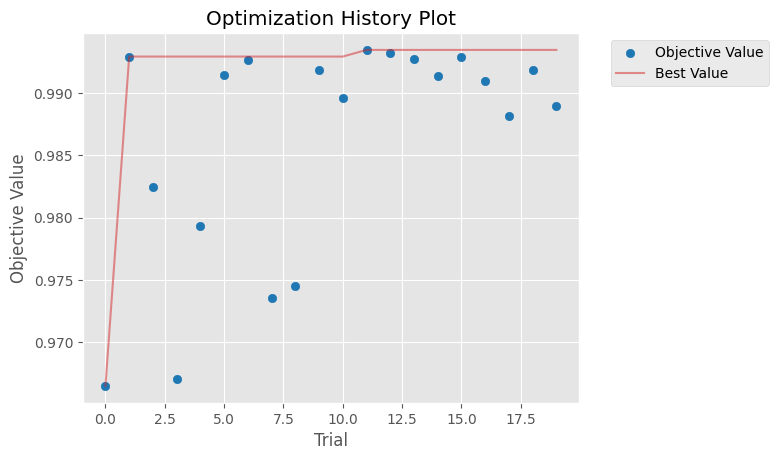

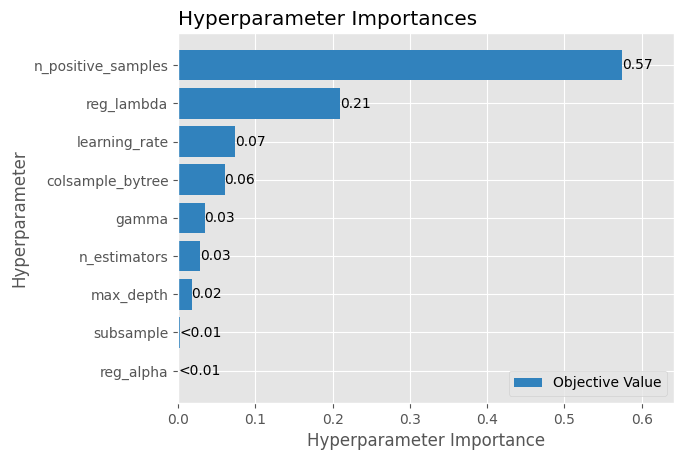

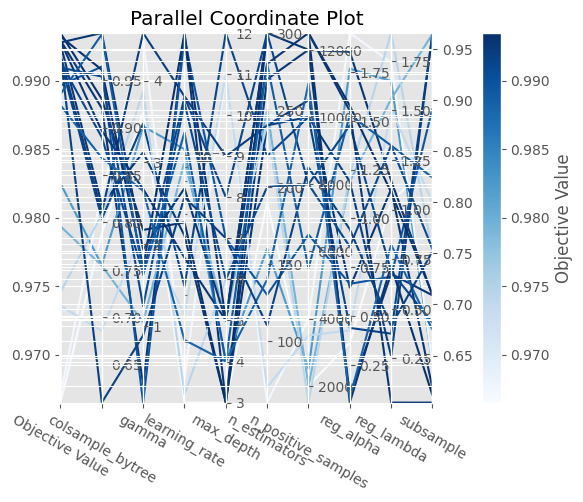

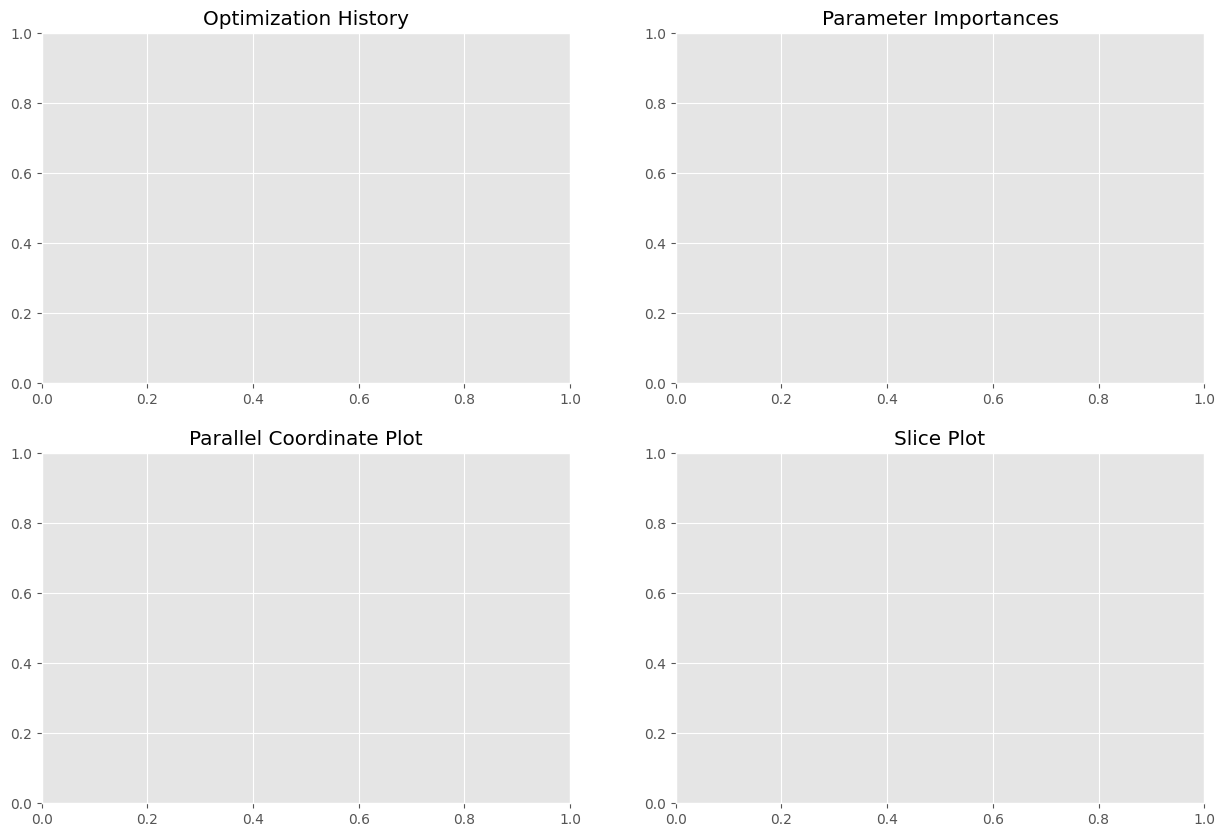

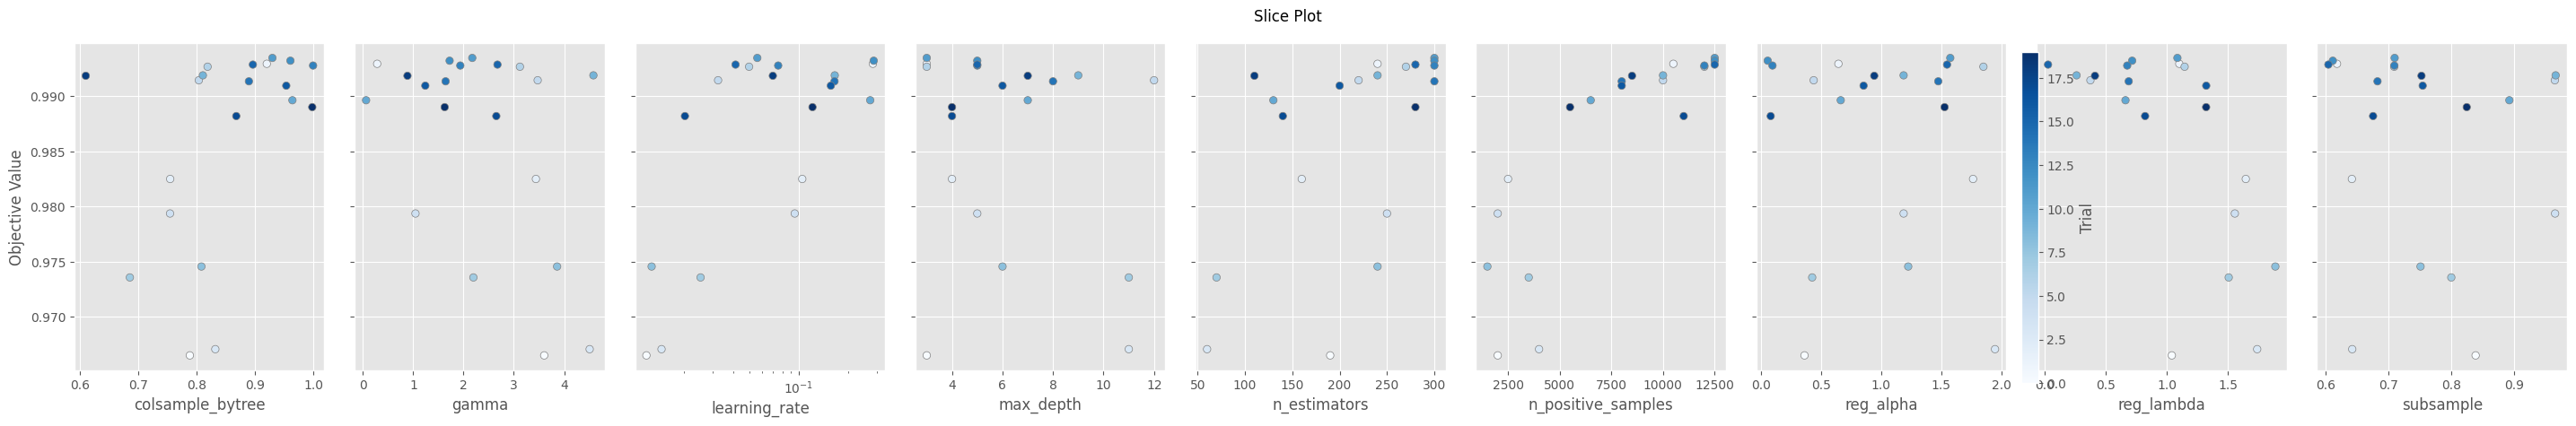

In [41]:
plot_optimization_results(results_xgb['study'])

In [43]:
confusion_matrix_xgb = confusion_matrix(results_xgb)

Matriz de Confusión:
 [[3835    5]
 [  23 2477]]

Verdaderos Positivos (TP): 2477
Falsos Positivos (FP): 5
Falsos Negativos (FN): 23
Verdaderos Negativos (TN): 3835

TPR (Sensibilidad/Recall) calculado manualmente: 0.9908
FPR calculado manualmente: 0.0013


In [68]:
results_xgb

{'study': <optuna.study.study.Study at 0x15e293250>,
 'best_params': {'n_estimators': 300,
  'max_depth': 3,
  'learning_rate': 0.056062565898828826,
  'subsample': 0.7094313851895123,
  'colsample_bytree': 0.9300477465683569,
  'gamma': 2.173147361992587,
  'reg_alpha': 1.5763907203935683,
  'reg_lambda': 1.087706503508744,
  'n_positive_samples': 12500},
 'cv_score': 0.9934719924314674,
 'test_score': 0.9943797671617824,
 'trained_model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.9300477465683569, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=2.173147361992587,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.056062565898828826,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
       

In [69]:
joblib.dump(results_xgb['scaler'], 'models/scaler_xgb.joblib')
joblib.dump(results_xgb['pca'], 'models/pca_xgb.joblib')
joblib.dump(results_xgb['trained_model'], 'models/xgb_optimized.joblib')

['models/xgb_optimized.joblib']

## Guardar datos importantes de los modelos

In [60]:
def extract_metrics(cm):
    # Si cm es un tuple, tomamos el primer elemento
    if isinstance(cm, tuple):
        cm = cm[0]
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    return tp, fp, fn, tn, tpr, fpr

In [ ]:
model_names = ['XGB', 'NN', 'GB']
results = [results_xgb, results_nn, results_gb]
cms = [confusion_matrix_xgb, confusion_matrix_nn, confusion_matrix_gb]

rows = []
for name, res, cm in zip(model_names, results, cms):
    tp, fp, fn, tn, tpr, fpr = extract_metrics(cm)
    row = {
        'model': name,
        'best_params': str(res['best_params']),
        'test_score': res['test_score'],
        'tpr': tpr,
        'fpr': fpr,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn
    }
    rows.append(row)

df = pd.DataFrame(rows)
print(df)

  model                                        best_params  test_score  \
0   XGB  {'n_estimators': 300, 'max_depth': 3, 'learnin...    0.994380   
1    NN  {'n_layers': 1, 'n_units_l0': 127, 'n_units_l1...    0.995218   
2    GB  {'n_estimators': 300, 'max_depth': 5, 'learnin...    0.994220   

        tpr       fpr    tp  fp  fn    tn  
0  0.990800  0.001302  2477   5  23  3835  
1  0.990952  0.000260  2081   1  19  3839  
2  0.989000  0.000260  1978   1  22  3839  


In [ ]:
df.to_csv("models_results.csv")